# Determinación de tipos de estrellas.

Este segundo caso práctico consiste en desarrollar el algoritmo K–Means. Con el objetivo principal de identificar grupos dentro de los datos, utilizando este método. En esta práctica vamos a explorar diferentes técnicas de aprendizaje no supervisado con datos categóricos ordinales. 

**Autores:**

- 100471948 - Celia Patricio Ferrer
- 100472039 - Alberto García de la Torre

---
## Librerías necesarias.
---

In [180]:
import time
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# KMeans de sklearn 
from sklearn.cluster import KMeans
# KMedois de sklearn
from sklearn_extra.cluster import KMedoids
from sklearn.datasets import make_blobs

# Silhouette
from sklearn.metrics import silhouette_score

# Modelo
from sklearn.pipeline import make_pipeline

# Escalar datos
from sklearn.preprocessing import scale, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA

# Dendograma
from scipy.cluster.hierarchy import dendrogram

# Modelo jerarquico
from sklearn.cluster import AgglomerativeClustering

# Warnings
import warnings
warnings.filterwarnings('ignore')

---
## Lectura del archivo.
---

In [181]:
stars_df = pd.read_csv('stars2.csv')

# Visualizar las primeras filas del archivo
stars_df.head()

,Temperature,L,R,A_M,Color,Spectral_Class
0,3068,0.002400,0.1700,16.12,Red,M
1,3042,0.000500,0.1542,16.60,Red,M
2,2600,0.000300,0.1020,18.70,Red,M
3,2800,0.000200,0.1600,16.65,Red,M
4,1939,0.000138,0.1030,20.06,Red,M


Los atributos son:

- `Temperature`: Temperatura promedio de la superficie en grados K.

- `L`: Luminosidad comparada con la del Sol.

- `R`: Radio comparado con la del Sol.

- `A_M`: Magnitud absoluta, brillo aparente de la estrella si estuviera a 10 parsec de distancia.

- `Color`: color principal del espectro.

- `Spectral_Class` o clasificación espectral: es un valor que identifica la presencia de elementos químicos en el espectro de la estrella.

### <u>Breve análisis de los datos</u>

Vamos a analizar brevemente el conjunto de datos que tenemos. 

In [182]:
# Imprimir el tamaño del dataframe.
print("El tamaño es:")
print(stars_df.shape)

El tamaño es:
(240, 6)


In [183]:
# Imprimir el tipo de atributos.
stars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Temperature     240 non-null    int64  
 1   L               240 non-null    float64
 2   R               240 non-null    float64
 3   A_M             240 non-null    float64
 4   Color           240 non-null    object 
 5   Spectral_Class  240 non-null    object 
dtypes: float64(3), int64(1), object(2)
memory usage: 11.4+ KB


**Categóricas o numéricas**

Ahora veremos si se tratan de columnas categóricas o columnas numéricas. En función de esto, deberemos manejar de una forma u otra cada una de estas columnas.

In [184]:
cat_columns = stars_df.select_dtypes(include=['object']).columns
num_columns = stars_df.select_dtypes(include=['int64', 'float64']).columns

print("Columnas categoricas:", cat_columns)
print("Columnas numéricas:", num_columns)

Columnas categoricas: Index(['Color', 'Spectral_Class'], dtype='object')
Columnas numéricas: Index(['Temperature', 'L', 'R', 'A_M'], dtype='object')


---
## K–Means.
---

En esta primera sección desarrollaremos la implementación de este algoritmo para comparar los resultados y la eficiencia de la implementación de *sklearn*.

In [185]:
class MiKMeans:
    def __init__(self, n_clusters=8, max_iter=300):
        self.n_clusters = n_clusters
        self.max_iter = max_iter

    def fit(self, X):
        # Inicialización de centroides aleatorios
        centroids_idx = np.random.choice(X.shape[0], size=self.n_clusters, replace=False)
        self.centroids = X[centroids_idx]

        for _ in range(self.max_iter):
            # Asignación de puntos al cluster más cercano
            distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
            labels = np.argmin(distances, axis=1)

            # Actualización de centroides
            new_centroids = np.array([X[labels == k].mean(axis=0) for k in range(self.n_clusters)])

            # Comprobación de convergencia
            if np.allclose(self.centroids, new_centroids):
                break

            self.centroids = new_centroids

    def predict(self, X):
        distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
        return np.argmin(distances, axis=1)

Esta implementación tiene un método `fit()` para entrenar el modelo y un método `predict()` para predecir las etiquetas de los datos de entrada.

### <u>Comparación</u>

En esta sección se comparan ambas implementaciones, la nuestra y la que ofrece SKlearn. Para esta comparación, la semilla elegida será el valor `0`, debido a que solo servirá para esta simulación inicial.

#### Make Blobs

Para la comparación de las dos implementaciones del algoritmo KMeans utilizaremos la simulación de datos generada  con `make_blobs()`, para que sea un conjunto de datos más sencillo.

Text(0.5, 1.0, 'Datos simulados')

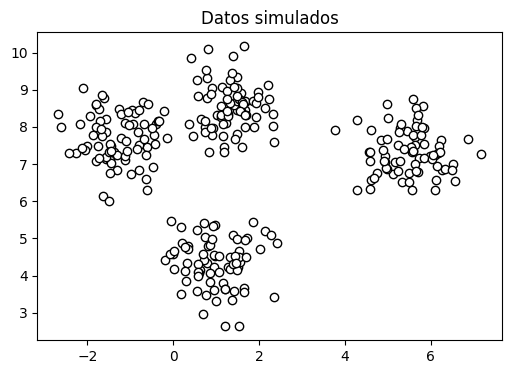

In [186]:
# Simulación de datos
X, y = make_blobs(
    n_samples    = 300,
    n_features   = 6,
    centers      = 4,
    cluster_std  = 0.60,
    shuffle      = True,
    random_state = 0
)

# Diagrama de dispersión
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.scatter(
    x = X[:, 0],
    y = X[:, 1],
    c = 'white',
    marker    = 'o',
    edgecolor = 'black',
)
ax.set_title('Datos simulados')

#### KMeans de SKlearn

In [187]:
# Modelo de sklearn
kmeans_sklearn = KMeans(n_clusters=4, n_init=25, random_state=0)
# Entrenar el modelo
t_inicio = time.time_ns()
kmeans_sklearn.fit(X)
t_fin = time.time_ns()
# Tiempo de entrenamiento
t_sklearn = t_fin - t_inicio

In [188]:
# Predicciones
y_pred_s = kmeans_sklearn.predict(X)

# Centroides
centroids_s = kmeans_sklearn.cluster_centers_

# Silhouette
score_s = silhouette_score(X, y_pred_s)

#### KMeans implementado

In [189]:
# Modelo implementado por nosotros
kmeans_custom = MiKMeans(n_clusters=4)
# Entrenar el modelo
t_inicio = time.time_ns()
kmeans_custom.fit(X)
t_fin = time.time_ns()
# Tiempo de entrenamiento
t_custom = t_fin - t_inicio

In [190]:
# Predicciones
y_pred_c = kmeans_custom.predict(X)

# Centroides
centroids_c = kmeans_custom.centroids

# Silhouette
score_c = silhouette_score(X, y_pred_c)

#### Resultados

In [191]:
# Mostrar los tiempos de entrenamiento
print(f"KMeans de sklearn:")
print(f"Tiempo de entrenamiento: {t_sklearn:.2f} s")
print(f"Silhouette: {score_s:.2f}")
print()
print(f"KMeans implementado por nosotros:")
print(f"Tiempo de entrenamiento: {t_custom:.2f} s")
print(f"Silhouette: {score_c:.2f}")

KMeans de sklearn:
Tiempo de entrenamiento: 25004842.00 s
Silhouette: 0.84

KMeans implementado por nosotros:
Tiempo de entrenamiento: 2011375.00 s
Silhouette: 0.46


Obtenemos que el tiempo de entrenamiento de la implementación llevada a cabo por nosotros es significativamente más rápida que la implementación de KMeans de SKlearn. En terminos de tiempo de ejecución, podemos decir que nuestra implementación es mejor. Sin embargo, para ver si globalmente es mejor, deberemos estudiar la precisión y la calidad de los resultados que esta obtiene. 

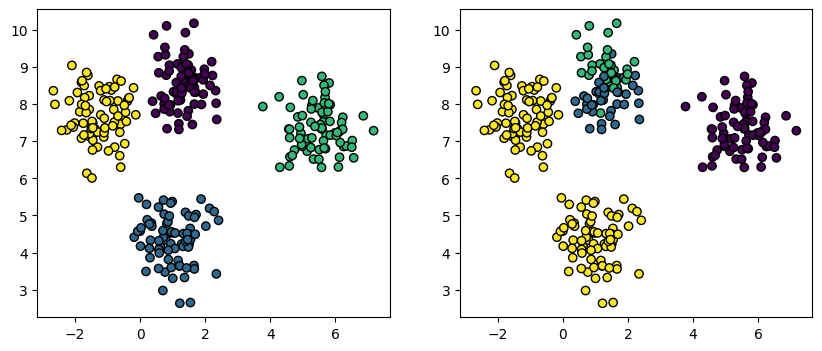

In [192]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Resultados para SKlearn
# ==============================================================================
ax[0].scatter(
    x = X[:, 0],
    y = X[:, 1],
    c = y_pred_s,
    #cmap='viridis',
    marker    = 'o',
    edgecolor = 'black'
)

# Resultados para nosotros
# ==============================================================================
ax[1].scatter(
    x = X[:, 0],
    y = X[:, 1],
    c = y_pred_c,
    #cmap='viridis',
    marker    = 'o',
    edgecolor = 'black'
)

Como podemos ver, los datos de esta simulación en ambas implementaciones se dibujan de la misma manera. Esto significa que la implementación llevada a cabo por nosotros está funcionando como se espera, obteniendo unos resultados similares en ambos algoritmos.

---
## Variables categóricas.
---

Como hemos visto anteriormente, este problema cuenta con dos variables categóricas `Color` y `Spectral_Class`.

### <u>One Hot Encoding</u>

En esta primera parte, trataremos las variables categóricas con la codificación `One–Hot–Encoding` para posteriormente aplicar diferentes algoritmos. 

In [193]:
X_one = stars_df.copy()

preprocessor = ColumnTransformer(
    transformers = [('categorical', OneHotEncoder(handle_unknown='ignore'), cat_columns),
                    ('scaler', StandardScaler(), num_columns)],
    remainder='passthrough'
)

# Entrenamos el preprocesador
preprocessor.fit(X_one)

ColumnTransformer(remainder='passthrough',
                  transformers=[('categorical',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 Index(['Color', 'Spectral_Class'], dtype='object')),
                                ('scaler', StandardScaler(),
                                 Index(['Temperature', 'L', 'R', 'A_M'], dtype='object'))])

Transformamos el conjunto de datos.

In [194]:
X_scaled_one = preprocessor.transform(X_one)

### <u>Categóricas ordinales</u>

En esta segunda parte, trataremos como variables categóricas con la codificiación de variables categóricas ordinales para su posterior comparación con los resultados obtenidos de la forma anterior. 

In [195]:
X_ord = stars_df.copy()

spectral_class = ("O", "B", "A", "F", "G", "K", "M")
# Pasar columnas categóricas ordinales a numéricas
X_ord['Spectral_Class'] = X_ord['Spectral_Class'].map(lambda x: spectral_class.index(x))

# Convierte los colores
colors = ["Red", "Orange-Red", "Orange", "Pale yellow orange", "Yellowish", "yellow-white", "Whitish", "Yellowish White", "White-Yellow", "White", "Blue-white", "Blue"]

# Iterar todos los elementos y modificarlos
X_ord['Color'] = X_ord['Color'].replace("Blue White", "Blue-white")
X_ord['Color'] = X_ord['Color'].replace("Blue white", "Blue-white")
X_ord['Color'] = X_ord['Color'].replace("Blue-White", "Blue-white")
X_ord['Color'] = X_ord['Color'].replace("white", "White")
X_ord['Color'] = X_ord['Color'].replace("yellowish", "Yellowish")

# Pasar columnas categóricas ordinales a numéricas
X_ord['Color'] = X_ord['Color'].map(lambda x: colors.index(x))

Aplicaremos el método `scale` para estandarizar características eliminando la media y escalando a la varianza unitaria.

In [201]:
X_scaled_ord = scale(X=X_ord, axis=0, with_mean=True, with_std=True)
X_scaled_ord_df = pd.DataFrame(X_scaled_ord, columns=stars_df.columns, index=stars_df.index)

<Axes: >

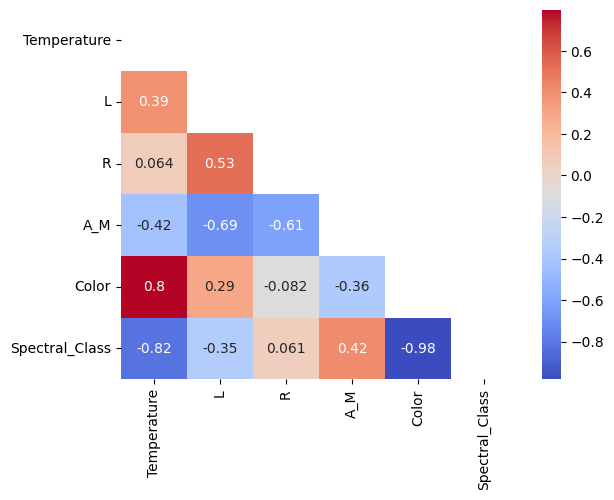

In [202]:
estados = X_ord.index
corr_df = X_ord.corr()
etiquetas = corr_df.columns

mask_ut = np.triu(np.ones(corr_df.shape)).astype(bool)
sns.heatmap(corr_df, mask=mask_ut, annot=True, cmap="coolwarm")

Hay una serie de variables que tienen una alta correlación. Esto indica que se puede realizar el análisis PCA, ya que tenemos la opción de transformar los datos de entrada y visualizarlos mediante dos dimensiones.

## PCA

In [206]:
np.set_printoptions(precision=2)

X = X_scaled_ord_df.values.squeeze()

pca = PCA(n_components=3)

X_trans = pca.fit_transform(X)

df_pca = pd.DataFrame(X_trans, columns=['PC1','PC2','PC3'])
df_pca.head()

,PC1,PC2,PC3
0,-2.067808,-0.147152,0.190962
1,-2.087328,-0.165090,0.195077
2,-2.188924,-0.236104,0.217676
3,-2.101169,-0.161525,0.198859
4,-2.273203,-0.273557,0.237536


<Axes: xlabel='PC1', ylabel='PC2'>

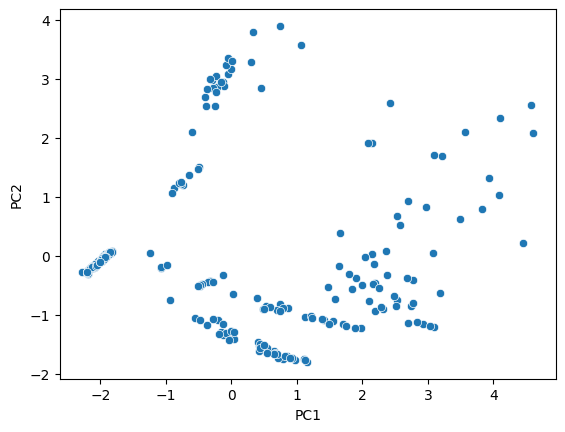

In [207]:
std = df_pca.describe().transpose()["std"]
sns.scatterplot(data=df_pca, x="PC1", y="PC2")

---
## Número de clusters.
---

Vamos a hacernos una función para determinar el valor óptimo del número de clusters, dado un método con nuestro conjunto de datos. En este método, dibujaremos la gráfica que se obtiene con el método silueta e identificaremos el mejor valor.

In [ ]:
# Dibujar el metodo silueta o silhouette method
def metodo_silueta(range_n_clusters, inertias, best_n_clusters, max_silhouette_score):
    # Graficar
    fig, ax = plt.subplots(1, 1, figsize=(12, 10))
    ax.plot(range_n_clusters, inertias, marker='o', color='purple')
    ax.set_title("Evolución de media de los índices Silhouette", size=20)
    ax.set_xlabel('Número clusters', size=14)
    ax.set_ylabel('Media índices silhouette', size=14)

    # Mejor número de clusters
    ax.text(best_n_clusters, max_silhouette_score, f'Max', 
            verticalalignment='bottom', horizontalalignment='center', fontsize=16)

    # Agregar una cuadrícula
    ax.grid(True)

    plt.show()

### Dendograma


In [ ]:
def plot_dendrogram(model, **kwargs):
    '''
    Esta función extrae la información de un modelo AgglomerativeClustering
    y representa su dendograma con la función dendogram de scipy.cluster.hierarchy
    '''

    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot
    dendrogram(linkage_matrix, **kwargs)

---
## Clustering: OneHotEncoding.
---

A continuación, aplicaremos diferentes algoritmos de *clustering* para finalmente comparar y discutir los resultados que obtenemos. Estos algoritmos primero los aplicaremos con el método de codificación *OneHotEncoding*.

### <u>K–Means</u>

El primer algoritmo que vamos a realizar es el `KMeans`. Utilizaremos el de *SKlearn* para que no repercuta una posible mala implementación por nuestra parte.

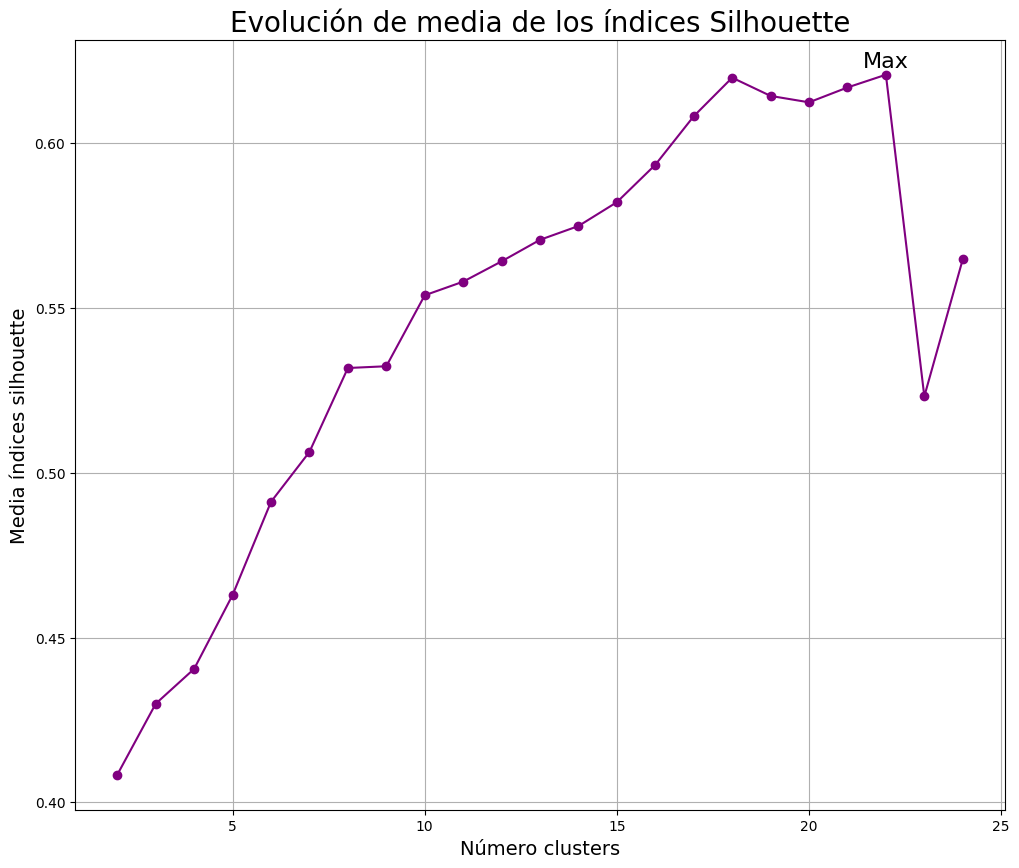

In [ ]:
# -------------------------------------------------------------------------
# Número de clusters
# -------------------------------------------------------------------------

range_n_clusters = range(2, 25)
valores_medios_silhouette = []

for n_clusters in range_n_clusters:
    modelo = KMeans(
        n_clusters   = n_clusters,
        n_init       = 25,
        random_state = 49
    )
    cluster_labels = modelo.fit_predict(X_scaled_one)
    silhouette_avg = silhouette_score(X_scaled_one, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)

# Encontrar el número de clústeres con la puntuación de silueta máxima
max_silhouette_idx = np.argmax(valores_medios_silhouette)
max_silhouette_score = valores_medios_silhouette[max_silhouette_idx]
best_n_clusters = range_n_clusters[max_silhouette_idx]

# Método silueta para datos escalados
metodo_silueta(range_n_clusters, valores_medios_silhouette, best_n_clusters, max_silhouette_score+0.001)

Como podemos ver, el valor óptimo del número de clusters es 22.

In [ ]:
# Modelo
modelo_kmeans_one = KMeans(n_clusters=22, n_init=25, random_state=49)
# Entrenar el modelo
modelo_kmeans_one.fit(X=X_scaled_one)

KMeans(n_clusters=22, n_init=25, random_state=49)

In [ ]:
# Predicciones
y_pred = modelo_kmeans_one.predict(X_scaled_one)
y_pred = modelo_kmeans_one.fit_predict(X_scaled_one)

### <u>K–Medoids</u>

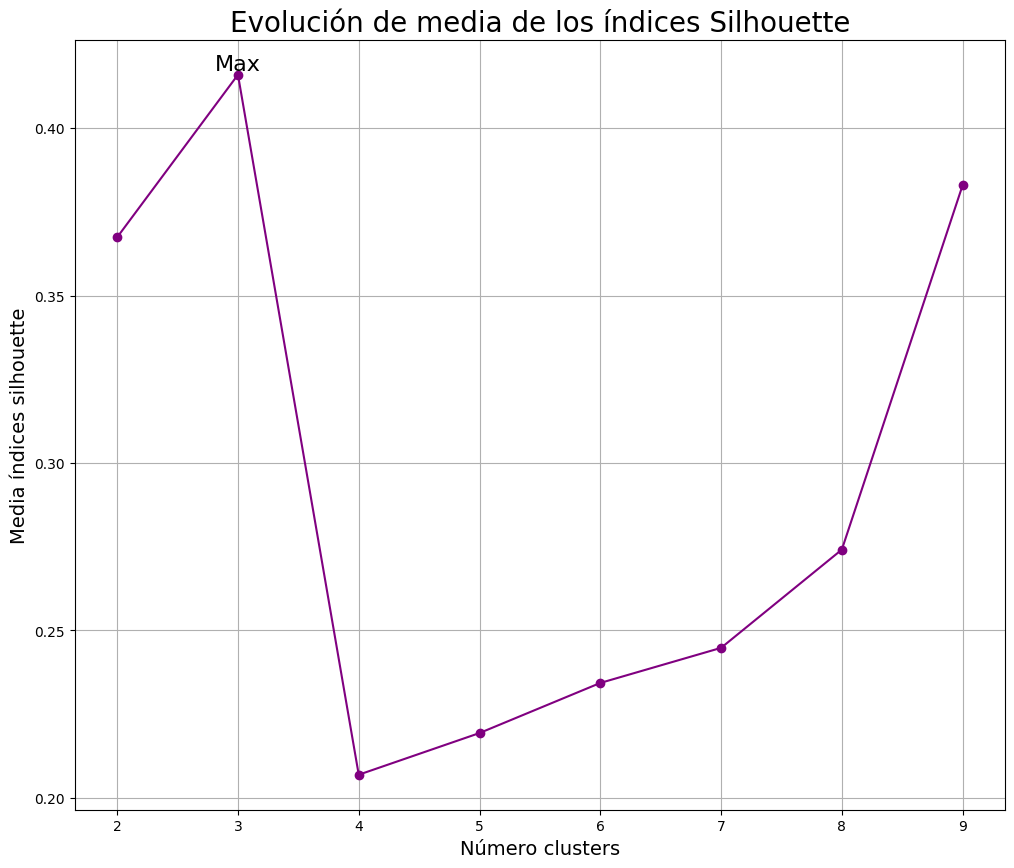

In [ ]:
# -------------------------------------------------------------------------
# Número de clusters
# -------------------------------------------------------------------------

range_n_clusters = range(2, 10)
valores_medios_silhouette = []

for n_clusters in range_n_clusters:
    modelo = KMedoids(
        n_clusters   = n_clusters,
        random_state = 49
    )
    cluster_labels = modelo.fit_predict(X_scaled_one)
    silhouette_avg = silhouette_score(X_scaled_one, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)

# Encontrar el número de clústeres con la puntuación de silueta máxima
max_silhouette_idx = np.argmax(valores_medios_silhouette)
max_silhouette_score = valores_medios_silhouette[max_silhouette_idx]
best_n_clusters = range_n_clusters[max_silhouette_idx]

# Método silueta para datos escalados
metodo_silueta(range_n_clusters, valores_medios_silhouette, best_n_clusters, max_silhouette_score+0.0001)

In [ ]:
# Modelo
modelo_kmedoids_one = KMedoids(n_clusters=19, random_state=49)
# Entrenar el modelo
modelo_kmedoids_one.fit(X=X_scaled_one)

KMedoids(n_clusters=19, random_state=49)

In [ ]:
# Predicciones
y_pred = modelo_kmedoids_one.predict(X_scaled_one)
y_pred = modelo_kmedoids_one.fit_predict(X_scaled_one)

### <u>Clustering jerárquico</u>

---
## Clustering: Ordinal.
---

En esta otra parte, aplicaremos los algoritmos de *clustering* aplicados anterioremnte para la comparación y discusión de los resultados que obtenemos. Pero, esta vez, los aplicaremos con el método de codificación con las variables categoricas ordinales.

### <u>K–Means</u>

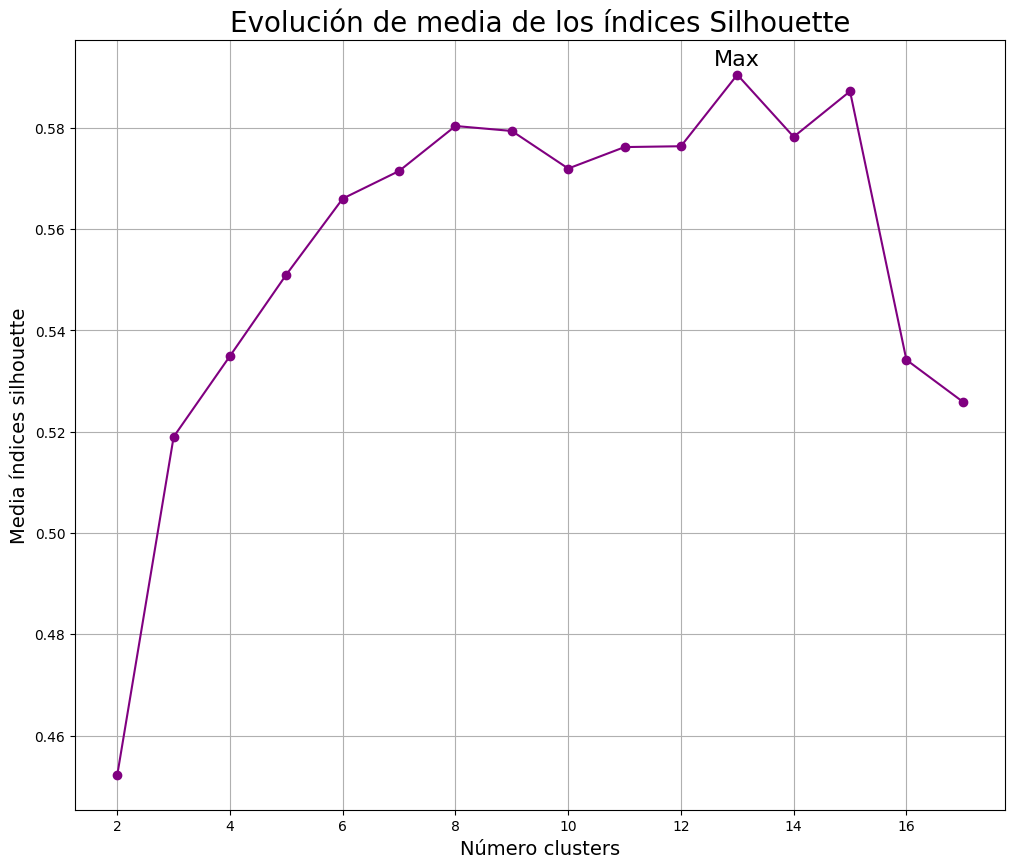

In [ ]:
# -------------------------------------------------------------------------
# Número de clusters
# -------------------------------------------------------------------------

range_n_clusters = range(2, 18)
valores_medios_silhouette = []

for n_clusters in range_n_clusters:
    modelo = KMeans(
        n_clusters   = n_clusters,
        n_init       = 25,
        random_state = 49
    )
    cluster_labels = modelo.fit_predict(X_scaled_ord)
    silhouette_avg = silhouette_score(X_scaled_ord, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)

# Encontrar el número de clústeres con la puntuación de silueta máxima
max_silhouette_idx = np.argmax(valores_medios_silhouette)
max_silhouette_score = valores_medios_silhouette[max_silhouette_idx]
best_n_clusters = range_n_clusters[max_silhouette_idx]

# Método silueta para datos escalados
metodo_silueta(range_n_clusters, valores_medios_silhouette, best_n_clusters, max_silhouette_score+0.001)

Como podemos ver el número óptimo de clusters es 13.

In [ ]:
# Modelo
modelo_kmeans_ord = KMeans(n_clusters=13, n_init=25, random_state=49)
# Entrenar el modelo
modelo_kmeans_ord.fit(X=X_scaled_ord)

KMeans(n_clusters=13, n_init=25, random_state=49)

In [ ]:
# Predicciones
y_pred = modelo_kmeans_ord.predict(X_scaled_ord)
y_pred = modelo_kmeans_ord.fit_predict(X_scaled_ord)

### <u>K–Medoids</u>

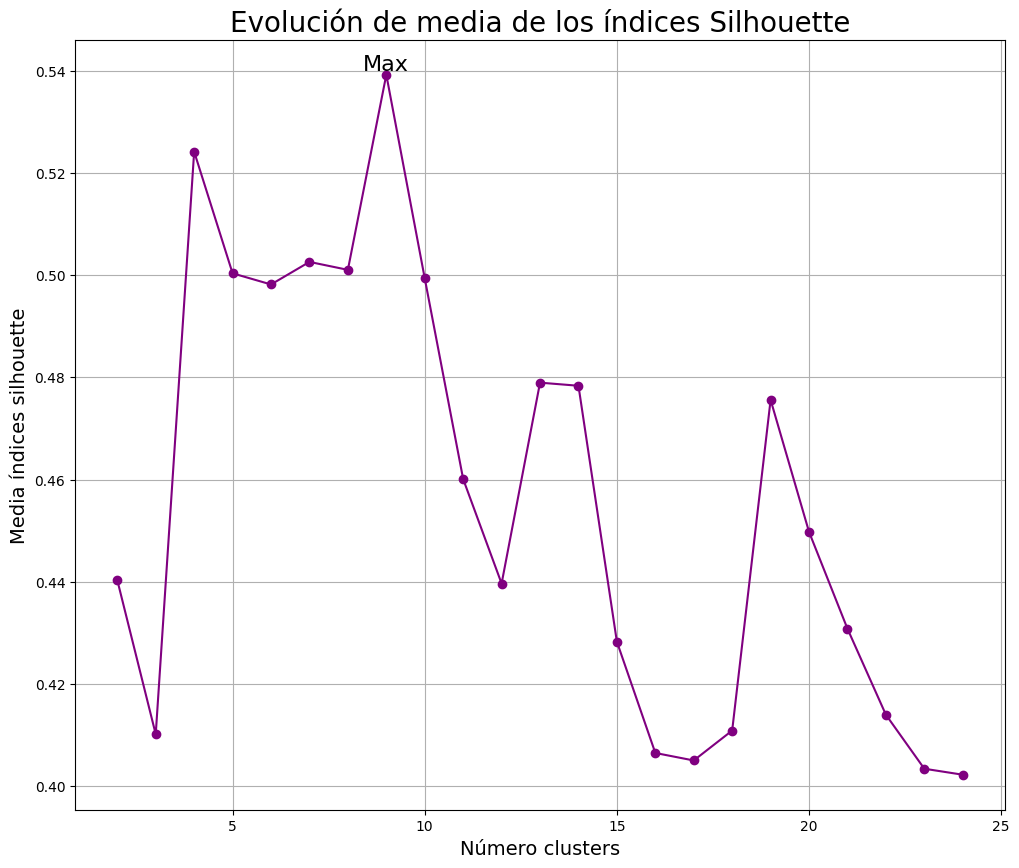

In [ ]:
# -------------------------------------------------------------------------
# Número de clusters
# -------------------------------------------------------------------------

range_n_clusters = range(2, 25)
valores_medios_silhouette = []

for n_clusters in range_n_clusters:
    modelo = KMedoids(
        n_clusters   = n_clusters,
        random_state = 49
    )
    cluster_labels = modelo.fit_predict(X_scaled_ord)
    silhouette_avg = silhouette_score(X_scaled_ord, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)

# Encontrar el número de clústeres con la puntuación de silueta máxima
max_silhouette_idx = np.argmax(valores_medios_silhouette)
max_silhouette_score = valores_medios_silhouette[max_silhouette_idx]
best_n_clusters = range_n_clusters[max_silhouette_idx]

# Método silueta para datos escalados
metodo_silueta(range_n_clusters, valores_medios_silhouette, best_n_clusters, max_silhouette_score+0.0001)

In [ ]:
# Modelo
modelo_kmedoids_ord = KMedoids(n_clusters=19, random_state=49)
# Entrenar el modelo
modelo_kmedoids_ord.fit(X=X_scaled_ord)

KMedoids(n_clusters=19, random_state=49)

In [ ]:
# Predicciones
y_pred = modelo_kmedoids_ord.predict(X_scaled_ord)
y_pred = modelo_kmedoids_ord.fit_predict(X_scaled_ord)

### <u>Clustering jerárquico</u>

In [ ]:
X_scaled_ord_dataframe = pd.DataFrame(data=X_scaled_ord, columns=X_ord.columns)

In [ ]:
modelo_hclust_complete = AgglomerativeClustering(
    affinity = 'euclidean',
    linkage  = 'complete',
    distance_threshold = 0,
    n_clusters         = None
)
modelo_hclust_complete.fit(X=X_scaled_ord_dataframe)

modelo_hclust_average = AgglomerativeClustering(
    affinity = 'euclidean',
    linkage  = 'average',
    distance_threshold = 0,
    n_clusters         = None
)
modelo_hclust_average.fit(X=X_scaled_ord_dataframe)

modelo_hclust_ward = AgglomerativeClustering(
    affinity = 'euclidean',
    linkage  = 'ward',
    distance_threshold = 0,
    n_clusters         = None
)
modelo_hclust_ward.fit(X=X_scaled_ord_dataframe)

TypeError: AgglomerativeClustering.__init__() got an unexpected keyword argument 'affinity'

NameError: name 'modelo_hclust_average' is not defined

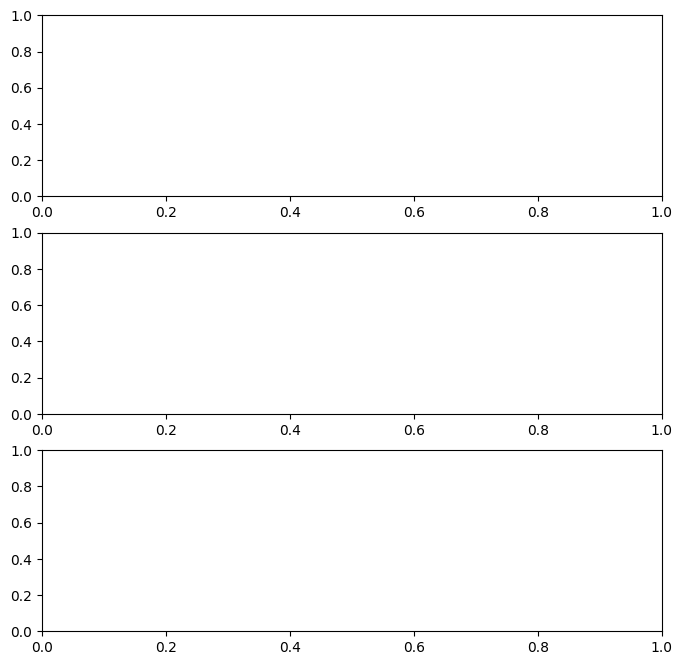

In [ ]:
# -------------------------------------------------------------------------
# Dendogramas
# -------------------------------------------------------------------------

fig, axs = plt.subplots(3, 1, figsize=(8, 8))
plot_dendrogram(modelo_hclust_average, labels=X_scaled_ord_dataframe.index, color_threshold=0, ax=axs[0])
axs[0].set_title("Distancia euclídea, Linkage average")
plot_dendrogram(modelo_hclust_complete, labels=X_scaled_ord_dataframe.index, color_threshold=0, ax=axs[1])
axs[1].set_title("Distancia euclídea, Linkage complete")
plot_dendrogram(modelo_hclust_ward, labels=X_scaled_ord_dataframe.index, color_threshold=0, ax=axs[2])
axs[2].set_title("Distancia euclídea, Linkage ward")
plt.tight_layout()

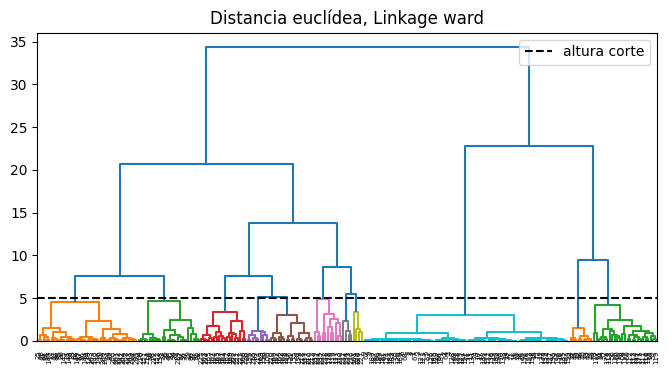

In [ ]:
# -------------------------------------------------------------------------
# Número de clusters
# -------------------------------------------------------------------------

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
altura_corte = 5
plot_dendrogram(modelo_hclust_ward, labels=X_scaled_ord_dataframe.index, color_threshold=altura_corte, ax=ax)
ax.set_title("Distancia euclídea, Linkage ward")
ax.axhline(y=altura_corte, c = 'black', linestyle='--', label='altura corte')
ax.legend()

In [ ]:
# -------------------------------------------------------------------------
# Número de clusters
# -------------------------------------------------------------------------

range_n_clusters = range(15, 25)
valores_medios_silhouette = []

for n_clusters in range_n_clusters:
    modelo = AgglomerativeClustering(
        affinity   = 'euclidean',
        linkage    = 'ward',
        n_clusters = n_clusters
    )

    cluster_labels = modelo.fit_predict(X_scaled_ord)
    silhouette_avg = silhouette_score(X_scaled_ord, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)

# Encontrar el número de clústeres con la puntuación de silueta máxima
max_silhouette_idx = np.argmax(valores_medios_silhouette)
max_silhouette_score = valores_medios_silhouette[max_silhouette_idx]
best_n_clusters = range_n_clusters[max_silhouette_idx]

# Método silueta para datos escalados
metodo_silueta(range_n_clusters, valores_medios_silhouette, best_n_clusters, max_silhouette_score+0.001)

TypeError: AgglomerativeClustering.__init__() got an unexpected keyword argument 'affinity'

---
---
---
---
---
---
---

## MAS MAS MAS.

### <u>Silhouette</u>

In [ ]:
""" range_n_clusters = range(10, 18)
valores_medios_silhouette = []

for n_clusters in range_n_clusters:
    modelo_kmeans = KMeans(
        n_clusters   = n_clusters,
        n_init       = 25,
        random_state = 49
    )
    cluster_labels = modelo_kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)

# Encontrar el número de clústeres con la puntuación de silueta máxima
max_silhouette_idx = np.argmax(valores_medios_silhouette)
max_silhouette_score = valores_medios_silhouette[max_silhouette_idx]
best_n_clusters = range_n_clusters[max_silhouette_idx]

# Graficar
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
ax.plot(range_n_clusters, valores_medios_silhouette, marker='o', color='purple')
ax.set_title("Evolución de media de los índices Silhouette", size=20)
ax.set_xlabel('Número clusters', size=14)
ax.set_ylabel('Media índices silhouette', size=14)

# Mejor número de clusters
ax.text(best_n_clusters, max_silhouette_score+0.001, f'Max', 
        verticalalignment='bottom', horizontalalignment='center', fontsize=16)

# Agregar una cuadrícula
ax.grid(True)

plt.show() """

' range_n_clusters = range(10, 18)\nvalores_medios_silhouette = []\n\nfor n_clusters in range_n_clusters:\n    modelo_kmeans = KMeans(\n        n_clusters   = n_clusters,\n        n_init       = 25,\n        random_state = 49\n    )\n    cluster_labels = modelo_kmeans.fit_predict(X_scaled)\n    silhouette_avg = silhouette_score(X_scaled, cluster_labels)\n    valores_medios_silhouette.append(silhouette_avg)\n\n# Encontrar el número de clústeres con la puntuación de silueta máxima\nmax_silhouette_idx = np.argmax(valores_medios_silhouette)\nmax_silhouette_score = valores_medios_silhouette[max_silhouette_idx]\nbest_n_clusters = range_n_clusters[max_silhouette_idx]\n\n# Graficar\nfig, ax = plt.subplots(1, 1, figsize=(12, 10))\nax.plot(range_n_clusters, valores_medios_silhouette, marker=\'o\', color=\'purple\')\nax.set_title("Evolución de media de los índices Silhouette", size=20)\nax.set_xlabel(\'Número clusters\', size=14)\nax.set_ylabel(\'Media índices silhouette\', size=14)\n\n# Mejor nú

Obtenemos que el mejor *silhouette* se obtiene con 13 clusters.